This Notebook is to run do exploratory data analysis on our dataset. 

--- Action Instance Counts ---
           Action Label  Instance Count
                   idle             143
                    jab              22
          rear_low_kick              14
                  cross              13
              side_kick              13
              lead_hook              11
               uppercut              11
              rear_hook              10
                   grab              10
spinning_back_high_kick               9
    crouching_low_sweep               9
               hadouken               9
          jumping_cross               6
              shoryuken               5


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'idle'),
  Text(1, 0, 'jab'),
  Text(2, 0, 'rear_low_kick'),
  Text(3, 0, 'cross'),
  Text(4, 0, 'side_kick'),
  Text(5, 0, 'lead_hook'),
  Text(6, 0, 'uppercut'),
  Text(7, 0, 'rear_hook'),
  Text(8, 0, 'grab'),
  Text(9, 0, 'spinning_back_high_kick'),
  Text(10, 0, 'crouching_low_sweep'),
  Text(11, 0, 'hadouken'),
  Text(12, 0, 'jumping_cross'),
  Text(13, 0, 'shoryuken')])

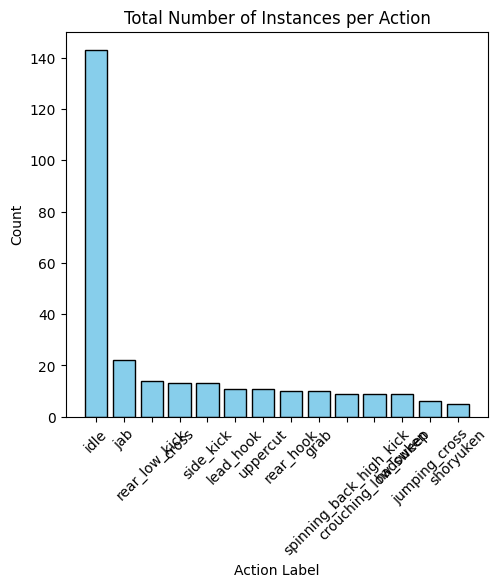

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the data
alfred_data = "Data/Phase2/Christian/pose_data_labeled_2.csv"
df = pd.read_csv(alfred_data)

# 2. Identify the label column (the last column)
label_col = df.columns[-1]

# 3. Create an Instance ID
# Marks 'True' every time the label changes from the previous row
df['change'] = df[label_col] != df[label_col].shift()
df['instance_id'] = df['change'].cumsum()

# 4. Group by instance to get the label and the duration (number of frames)
instance_df = df.groupby('instance_id').agg(
    label=(label_col, 'first'),
    duration=(label_col, 'count')
)

# 5. Create the Summary Table: Total count of instances per action class
summary_table = instance_df['label'].value_counts().reset_index()
summary_table.columns = ['Action Label', 'Instance Count']

print("--- Action Instance Counts ---")
print(summary_table.to_string(index=False))

# 6. Create Visualizations (Pure Matplotlib)
plt.figure(figsize=(12, 5))

# Plot A: Bar Chart of Instance Counts
plt.subplot(1, 2, 1)
plt.bar(summary_table['Action Label'], summary_table['Instance Count'], color='skyblue', edgecolor='black')
plt.title('Total Number of Instances per Action')
plt.xlabel('Action Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
